# Higher Order Linear System Analysis

Instead of estimating: $x(t+1) = Ax(t)$, we now estimate:

$x(t+1) = A_1x(t) + A_2 x(t-1) + ... + A_d x(t-d+1)$

and run the perturbation algorithm on $A_1, A_2, ..., A_d$.

In [1]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt

import pydmd

from eztrack.io.base import _add_desc_to_bids_fname
from eztrack.io import read_derivative_npy
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                SystemIDModel, StructuredPerturbationModel, compute_brauer_rank_one)
from eztrack.fragility.hofragility import lds_raw_hofragility
from eztrack.fragility.mvarmodel import inner_transpose_multicompanion
from eztrack.utils import Normalize, assert_structured_perturbation_eigvals
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

_load_turbo()

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Configure Paths and BIDS related metadata

In [2]:
# load in originally ran npy data
root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/')
# root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives'
reference = 'monopolar'
deriv_chain = Path('originalsampling') / 'radius1.5' / 'fragility' / reference

sessions = ['extraoperative', 'preresection', 
            'intraresection', 'postresection']
desc = 'perturbmatrix'

In [3]:
subject = 'E1'
session = 'extraoperative'
acquisition = 'ecog'
run = '01'
datatype = 'ieeg'
extension = '.vhdr'

# subject = 'pt1'
# session = 'presurgery'
# acquisition = 'ecog'
# run = '01'

In [4]:
subjects = get_entity_vals(root, 'subject')
ignore_subjects = [sub for sub in subjects if sub != subject]

sessions = get_entity_vals(root, 'session', ignore_subjects=ignore_subjects)
ignore_sessions = [ses for ses in sessions if ses != session]

tasks = get_entity_vals(root, 'task', 
                        ignore_subjects=ignore_subjects,
                        ignore_sessions=ignore_sessions
                       )

print(tasks)
task = tasks[-1]

print(task)

['ictal', 'interictalasleep', 'interictalawake']
interictalawake


In [5]:
bids_path = BIDSPath(subject=subject, session=session,task=task,
                    acquisition=acquisition, run=run, suffix=datatype,
                    datatype=datatype, extension=extension,
                    root=root)
print(bids_path)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/ses-extraoperative/ieeg/sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.vhdr


# Load raw data

In [6]:
raw = read_raw_bids(bids_path, verbose=False)

print(raw)

<RawBrainVision | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.eeg, 148 x 618112 (301.6 s), ~352 kB, data not loaded>


<ipython-input-6-93eddeff2657>:1: RuntimeWarning: Did not find any events.tsv associated with sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/**/sub-E1_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-6-93eddeff2657>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'IPD1', 'IPD2', 'IPD3', 'IPD4', 'IPD5', 'IPD6', 'IAD1', 'IAD2', 'IAD3', 'IAD4', 'IAD5', 'IAD6', 'SAD1', 'SAD2', 'SAD3', 'SAD4', 

In [7]:
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = raw.info['line_freq']
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

raw = raw.notch_filter(freqs, method='fir')

<RawBrainVision | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.eeg, 98 x 618112 (301.6 s), ~462.4 MB, data loaded>


# Low/High Filtered Data

In [8]:
rawlow = raw.copy().filter(l_freq=l_freq, h_freq=55)
rawhigh = raw.copy().filter(l_freq=55, h_freq=200)

low_data = rawlow.get_data(start=0, stop=2000)
high_data = rawhigh.get_data(start=0, stop=2000) 
high_data = high_data * (low_data.max() / high_data.max() + low_data.min() / high_data.min())/2.
eegwin = np.concatenate((low_data, high_data), axis=0)
print(eegwin.shape)

(196, 2000)


0.0009461324093962852
0.0006192212462667913
0.0004623167750644936
-0.0004948605958547237 -0.0003269111631294939
1.3393873630919177 0.6606126369080824
0.0009571773709192172


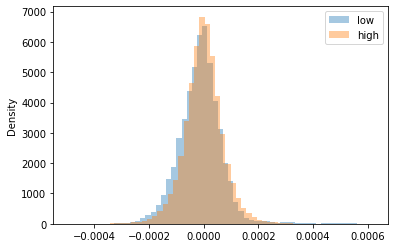

In [9]:
print(low_data.max() - low_data.min())
print(low_data.max())
print(high_data.max())
print(high_data.min(), low_data.min())
print(low_data.max() / high_data.max(), low_data.min() / high_data.min())
print(high_data.max() - high_data.min())

fig, ax = plt.subplots()
sns.distplot(low_data, ax=ax,label='low')
sns.distplot(high_data, ax=ax, label='high')
ax.legend()

<ipython-input-31-8591b6bbe552>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'C40', 'IAD6', 'IPD4', 'C10', 'MAOD2', 'SPD4', 'C20', 'C8', 'C53', 'C30', 'MAOD4', 'C26', 'C36', 'C24', 'IAD4', 'C48', 'C5', 'IAD2', 'IAD1', 'C21', 'C13', 'C4', 'C35', 'IPD1', 'MPOD2', 'C23', 'MPOD1', 'IPD6', 'C2', 'SPD3', 'C43', 'C7', 'C17', 'C18', 'C45', 'C29', 'C49', 'C42', 'C37', 'SAD5', 'MPOD4', 'C47', 'C32', 'MAOD5', 'MPOD3', 'C62', 'C52', 'C39', 'C19', 'IPD3', 'SPD1', 'C51', 'C61', 'C33', 'C31', 'IPD2', 'C22', 'C44', 'SPD6', 'C27', 'C59', 'C41', 'C46', 'C34', 'SPD2', 'SAD4', 'C55', 'C56', 'C6', 'SAD2', 'IAD5', 'MAOD6', 'C11', 'C14', 'IPD5', 'C16', 'SAD3', 'C12', 'C54', 'MAOD3', 'MPOD6', 'C38', 'C50', 'MPOD5', 'C28', 'IAD3', 'C64', 'C63', 'C3', 'C60', 'C1', 'SAD6', 'SPD5', 'C58', 'C25', 'C9', 'SAD1', 'MAOD1'}. Applying running numbers for duplicates.
  ch_types=np.tile(raw.get_channel_types(), 2).tolist())
<ipython-input-31-8591b6bbe552>:4: RuntimeWarning: Channel locations not

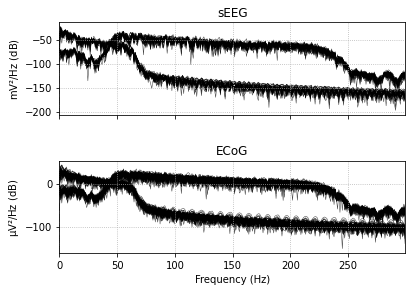

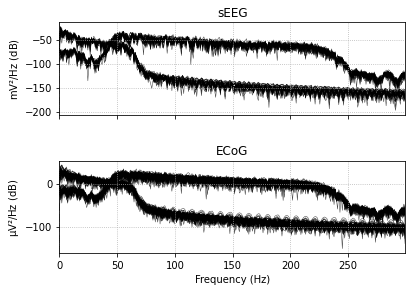

In [31]:

testinfo = mne.create_info(ch_names=np.tile(raw.ch_names, 2).tolist(), sfreq=raw.info['sfreq'], 
                          ch_types=np.tile(raw.get_channel_types(), 2).tolist())
rawarray = mne.io.RawArray(eegwin, info=testinfo)
rawarray.plot_psd(fmax=300)

In [15]:
# create time-shifted snapshots
snapshot_A = eegwin[:, :-1]  # x(t)
snapshot_B = eegwin[:, 1:]  # x(t+1)

# adjmat = snapshot_B.dot(np.linalg.pinv(snapshot_A))

##### l2 penalty
l2penalty = 1e-9
numchans = eegwin.shape[0]

# apply perturbation on diagonal
inner_regularized = (snapshot_A.dot(snapshot_A.T) + l2penalty * np.eye(numchans))
_tikhonov_pinv_mat = snapshot_A.T.dot(np.linalg.inv(inner_regularized))
adjmat = snapshot_B.dot(_tikhonov_pinv_mat)

##### truncated SVD
# U, s, V = np.linalg.svd(snapshot_A, full_matrices=False)
# V = V.conj().T

# # compute optimal rank
# omega = lambda x: 0.56 * x ** 3 - 0.95 * x ** 2 + 1.82 * x + 1.43
# beta = np.divide(*sorted(snapshot_A.shape))
# tau = np.median(s) * omega(beta)
# rank = np.sum(s > tau)

# # print(rank)
# # rank = len(raw.ch_names)
# # truncate the rank
# U = U[:, :rank]
# V = V[:, :rank]
# s = s[:rank]

# adjmat = snapshot_B.dot(V * np.reciprocal(s)).dot(U.conj().T)

957.7229865430779
1.003032752381362
[0.99835879 0.99835879 0.99483885 0.99483885 0.99248496]


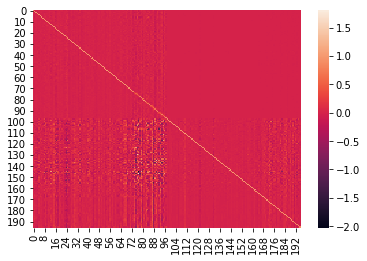

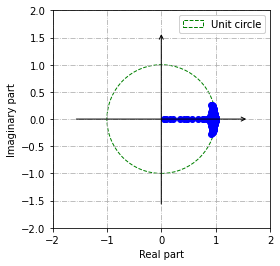

In [17]:
sns.heatmap(adjmat)

lds = DiscreteLinearSystem(adjmat)
lds.plot_eigs()
print(lds.cond)
print(np.abs(lds.eigs).max())
print(np.abs(lds.eigs)[-5:])

In [22]:
pertmodel = StructuredPerturbationModel(radius=1.25, perturb_type='C', perturbation_strategy='univariate')

In [23]:
print(len(raw.ch_names))

98


In [24]:
# delta_vec = pertmodel._compute_minimum_norm_perturbation2(adjmat, desired_eig=1.25, indices=[0, 98], 
#                                                          perturb_type='C')
delta_vec = pertmodel.fit(adjmat)

In [26]:
frag_vec = Normalize().compute_fragilitymetric(delta_vec[:, np.newaxis])

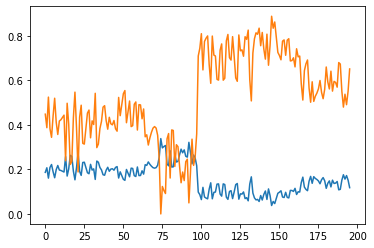

In [27]:
plt.plot(delta_vec)
plt.plot(frag_vec)

(196,)


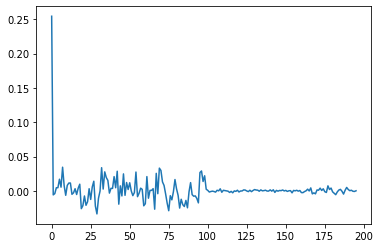

In [74]:
print(delta_vec.shape)

plt.plot(delta_vec)

In [21]:
eegwin = raw.get_data(start=0, stop=500)

# create time-shifted snapshots
snapshot_A = eegwin[:, :-1]  # x(t)
snapshot_B = eegwin[:, 1:]  # x(t+1)

adjmat = snapshot_B.dot(np.linalg.pinv(snapshot_A))

In [25]:
norms = pertmodel.fit(adjmat)

In [40]:
n_chs = len(raw.ch_names)

In [42]:
print(adjmat.shape)

test_adjmat = adjmat.copy()
test_adjmat[:n_chs, 0] += delta_vec[:n_chs]
test_adjmat[n_chs:, n_chs] += delta_vec[n_chs:]


(196, 196)


13540.750387710443
1.2497970026710896
[4.31835484e-01 4.16241979e-01 2.60124023e-01 2.30308616e-01
 2.37591359e-01 2.10001306e-01 1.99586317e-01 1.90152359e-01
 1.66607828e-01 1.66607828e-01 1.48713492e-01 1.38873040e-01
 1.28214475e-01 1.23197679e-01 1.12636211e-01 1.06912901e-01
 8.73531853e-02 8.73531853e-02 7.46653200e-02 6.33262971e-02
 5.59737050e-02 4.96055086e-02 4.44623121e-02 3.78114733e-02
 2.48390146e-01 3.51407438e-01 3.17933635e-01 2.95142230e-01
 2.83692981e-01 3.38424203e-02 3.12525471e-02 3.05501601e-01
 2.63436343e-02 2.10814818e-02 2.97589611e-02 1.47722483e-02
 1.63063428e-02 1.63063428e-02 1.82204762e-02 1.09457758e-02
 6.25764164e-03 5.77949547e-03 8.71190360e-03 9.03001937e-03
 3.97893982e-03 6.97744303e-04 1.18352600e-03 1.85696476e-03
 2.52172584e-03 2.36821241e-03 4.03071619e-01 1.58063452e-03
 4.92754295e-04 1.79205637e-04 3.11520001e-04 2.07700314e-04
 3.89246471e-01 4.79003911e-01 1.24979700e+00 4.97332229e-01
 5.17365779e-01 5.34265918e-01 5.73535977e-01 5

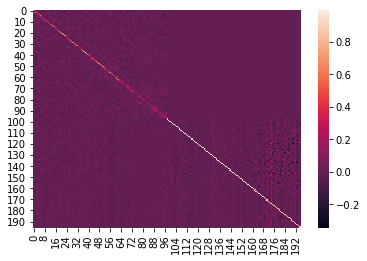

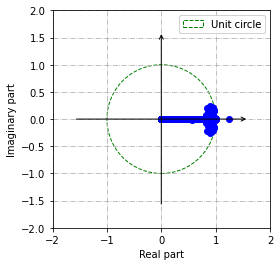

In [43]:
sns.heatmap(test_adjmat)

lds = DiscreteLinearSystem(test_adjmat)
lds.plot_eigs()
print(lds.cond)
print(np.abs(lds.eigs).max())
print(np.abs(lds.eigs))

<AxesSubplot:ylabel='Density'>

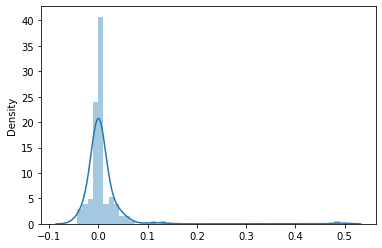

In [37]:
delta_vec = pertmodel._compute_minimum_norm_perturbation2(adjmat, desired_eig=1.25, indices=[0], 
                                                         perturb_type='C')
sns.distplot(delta_vec)

# Effect of Regularization, Truncation

In [15]:
eegwin = raw.get_data(start=0, stop=500)

# create time-shifted snapshots
snapshot_A = eegwin[:, :-1]  # x(t)
snapshot_B = eegwin[:, 1:]  # x(t+1)

l2penalty = 1e-6
numchans = len(raw.ch_names)

In [28]:
# truncated SVDa
U, s, V = np.linalg.svd(snapshot_A, full_matrices=False)
V = V.conj().T

# compute optimal rank
omega = lambda x: 0.56 * x ** 3 - 0.95 * x ** 2 + 1.82 * x + 1.43
beta = np.divide(*sorted(snapshot_A.shape))
tau = np.median(s) * omega(beta)
rank = np.sum(s > tau)

print(rank)

# truncate the rank
U = U[:, :rank]
V = V[:, :rank]
s = s[:rank]

adjmat = snapshot_B.dot(V * np.reciprocal(s)).dot(U.conj().T)

38


1.0092391048036384
[9.88855678e-01 9.88855678e-01 9.77998848e-01 9.77998848e-01
 9.88408678e-01 9.88408678e-01 9.88632249e-01 9.88632249e-01
 9.87799680e-01 9.87799680e-01 9.77662629e-01 9.77662629e-01
 9.87821205e-01 9.87821205e-01 9.88840014e-01 9.88840014e-01
 1.00046706e+00 1.00046706e+00 9.85611499e-01 9.85611499e-01
 9.60619338e-01 9.94084771e-01 9.94084771e-01 9.96837246e-01
 9.96837246e-01 9.97537953e-01 9.97537953e-01 1.00189581e+00
 1.00189581e+00 1.00152425e+00 1.00152425e+00 1.00923910e+00
 1.00923910e+00 1.00854933e+00 1.00493610e+00 1.00493610e+00
 9.93843878e-01 9.93843878e-01 3.23027038e-16 2.72693207e-16
 2.57852595e-16 2.57852595e-16 2.36087458e-16 2.36087458e-16
 2.17810956e-16 2.17810956e-16 2.19061439e-16 2.19061439e-16
 2.05151070e-16 2.05151070e-16 1.94441550e-16 1.94441550e-16
 2.00231324e-16 2.00231324e-16 1.74189480e-16 1.85174677e-16
 1.85174677e-16 1.87539350e-16 1.87539350e-16 1.62809816e-16
 1.62809816e-16 1.52895579e-16 1.52895579e-16 1.42906590e-16
 1.42

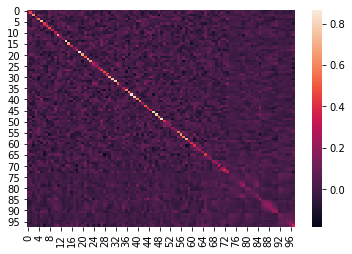

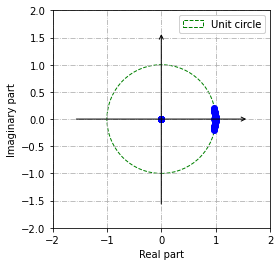

In [38]:
sns.heatmap(adjmat)

lds = DiscreteLinearSystem(adjmat)
lds.plot_eigs()
print(np.abs(lds.eigs).max())
print(np.abs(lds.eigs))

77425141.21505605
1746.0823200893974


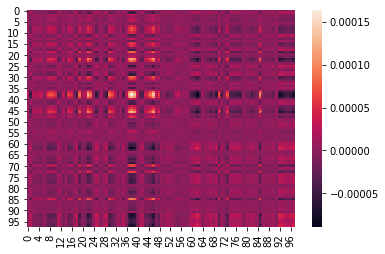

In [17]:
# inner matrix in Tikhonov regularization
inner_regularized = (snapshot_A.dot(snapshot_A.T))
sns.heatmap(inner_regularized)
print(np.linalg.cond(inner_regularized))

lds = DiscreteLinearSystem(inner_regularized)

inner_regularized = inner_regularized + l2penalty * np.eye(numchans)

reglds = DiscreteLinearSystem(inner_regularized)
print(np.linalg.cond(inner_regularized))

In [22]:
print(lds.eigs)

print(reglds.eigs)

[1.74512168e-03 1.93353708e-04 1.44060209e-05 6.61544572e-06
 1.48743194e-06 8.13574026e-07 5.62700382e-07 3.60177692e-07
 3.20259515e-07 1.69562536e-07 1.36754786e-07 1.11711314e-07
 1.03741387e-07 8.79095031e-08 7.46750755e-08 5.91771931e-08
 4.72520061e-08 4.26451314e-08 3.64479498e-08 3.14590163e-08
 2.90638383e-08 2.54232224e-08 2.12645441e-08 1.83058902e-08
 1.79139490e-08 1.38425281e-08 1.34392134e-08 1.06747519e-08
 1.10039043e-08 9.02236042e-09 8.69263942e-09 8.10544595e-09
 7.55302150e-09 6.22013516e-09 5.99784909e-09 4.64889163e-09
 4.10898949e-09 3.95645256e-09 3.82734533e-09 2.87692037e-09
 2.61952300e-09 2.39179815e-09 2.09132957e-09 1.96528769e-09
 1.85785969e-09 1.75138868e-09 1.44888278e-09 1.42809854e-09
 1.32115531e-09 1.22489691e-09 1.09696136e-09 1.00434202e-09
 9.34226572e-10 9.09243134e-10 7.70973919e-10 6.60034103e-10
 6.51370308e-10 6.22101426e-10 5.29405404e-10 4.96926331e-10
 4.58903319e-10 4.15141725e-10 3.95126188e-10 3.62121654e-10
 3.21583353e-10 2.947432

In [39]:
pertmodel = MinNormPerturbModel(radius=1.25, perturb_type='C')

In [40]:
min_norms = pertmodel.fit(adjmat)

<AxesSubplot:ylabel='Density'>

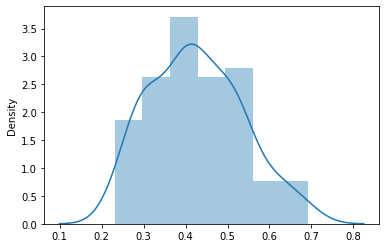

In [41]:
sns.distplot(min_norms)

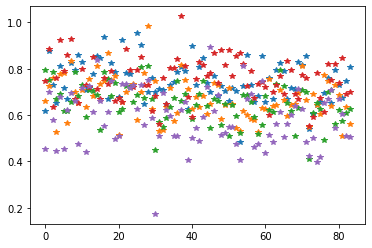

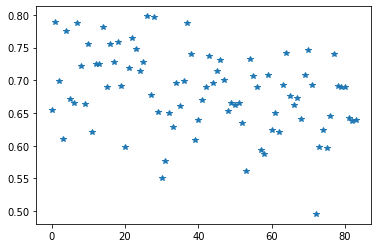

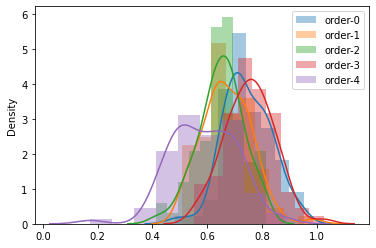

In [20]:
fig, ax = plt.subplots()
for x in min_norms:
    ax.plot(x, '*')
    
plt.figure()
plt.plot(np.mean(min_norms, axis=0), '*')

plt.figure()
for idx, x in enumerate(min_norms):
    sns.distplot(x, label=f'order-{idx}')
plt.legend()

# Using Bayesian Information Criterion to Determine Order

In [ ]:
def select_order():
    pass

# Run Algorithm on pt1

In [8]:
subject = 'pt1'
session = 'presurgery'
acquisition = 'ecog'
run = '01'
task = 'ictal'

root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')

In [9]:
bids_path = BIDSPath(subject=subject, session=session,task=task,
                    acquisition=acquisition, run=run, suffix=datatype,
                    datatype=datatype, extension=extension,
                    root=root)
print(bids_path)

/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/ses-presurgery/ieeg/sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr


In [10]:
raw = read_raw_bids(bids_path, verbose=False)

print(raw)

<RawBrainVision | sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 98 x 269080 (269.1 s), ~189 kB, data not loaded>


<ipython-input-10-93eddeff2657>:1: RuntimeWarning: Did not find any electrodes.tsv associated with sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*electrodes.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-10-93eddeff2657>:1: RuntimeWarning: Did not find any coordsystem.json associated with sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*coordsystem.json"
  raw = read_raw_bids(bids_path, verbose=False)


In [11]:
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = raw.info['line_freq']
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

raw = raw.notch_filter(freqs, method='fir')

<RawBrainVision | sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 84 x 269080 (269.1 s), ~172.6 MB, data loaded>


In [13]:
rawcopy = raw.copy() #.crop(0, 5)
print(rawcopy)

<RawBrainVision | sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 84 x 269080 (269.1 s), ~172.6 MB, data loaded>


In [14]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(rawcopy, return_all=True, order=3, radius='adaptive')

Fragility Heatmap:   0%|          | 0/716 [00:00<?, ?eeg window/s]

Using pinv least squares with l2penalty 0.
Data matrix shape input: (84, 269080). Estimate state array with LTI Window Model | order=3, l2_penalty=0, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=adaptive, perturb_type=C.


Fragility Heatmap: 100%|██████████| 716/716 [06:00<00:00,  1.99eeg window/s]


(84,) (252, 252) (84, 252)


/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Channel names are not unique, found duplicates for: {'G21', 'ATT5', 'G28', 'ILT2', 'G25', 'MLT4', 'G1', 'G2', 'G12', 'AD1', 'MLT1', 'MLT3', 'G19', 'IF6', 'PLT3', 'AD2', 'SLT3', 'PST2', 'IF2', 'AD3', 'ATT6', 'ILT4', 'ATT8', 'PD3', 'G29', 'G23', 'AST1', 'ATT7', 'AD4', 'ILT1', 'G30', 'PLT6', 'G7', 'G9', 'G17', 'PD2', 'SLT1', 'SF3', 'G32', 'PLT2', 'G15', 'SF5', 'SLT4', 'AST3', 'SF1', 'PST3', 'ATT2', 'PD4', 'PST1', 'IF3', 'G26', 'SF4', 'G4', 'ATT1', 'G22', 'IF4', 'SLT2', 'G10', 'ATT4', 'PST4', 'G18', 'SF2', 'G20', 'G31', 'AST4', 'PD1', 'G27', 'G16', 'G3', 'G8', 'IF5', 'ILT3', 'ATT3', 'G13', 'G11', 'PLT4', 'PLT5', 'SF6', 'G14', 'G24', 'IF1', 'PLT1', 'AST2', 'MLT2'}. Applying running numbers for duplicates.
  mne_warn(message, category, module)
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part

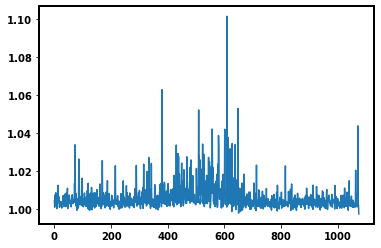

In [18]:
n_wins = len(pert_deriv)
radiis = []

A_mats = state_deriv.get_data()
for idx in range(n_wins):
    A = A_mats[..., idx]
    spectral_radii = np.abs(np.linalg.eigvals(A)).max()
    radiis.append(spectral_radii)
plt.plot(radiis)

<DerivativeArray | None,  - shape: ((84, 716)) (84 chs x 716 times) (268.1 s), ~631 kB, data loaded>


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

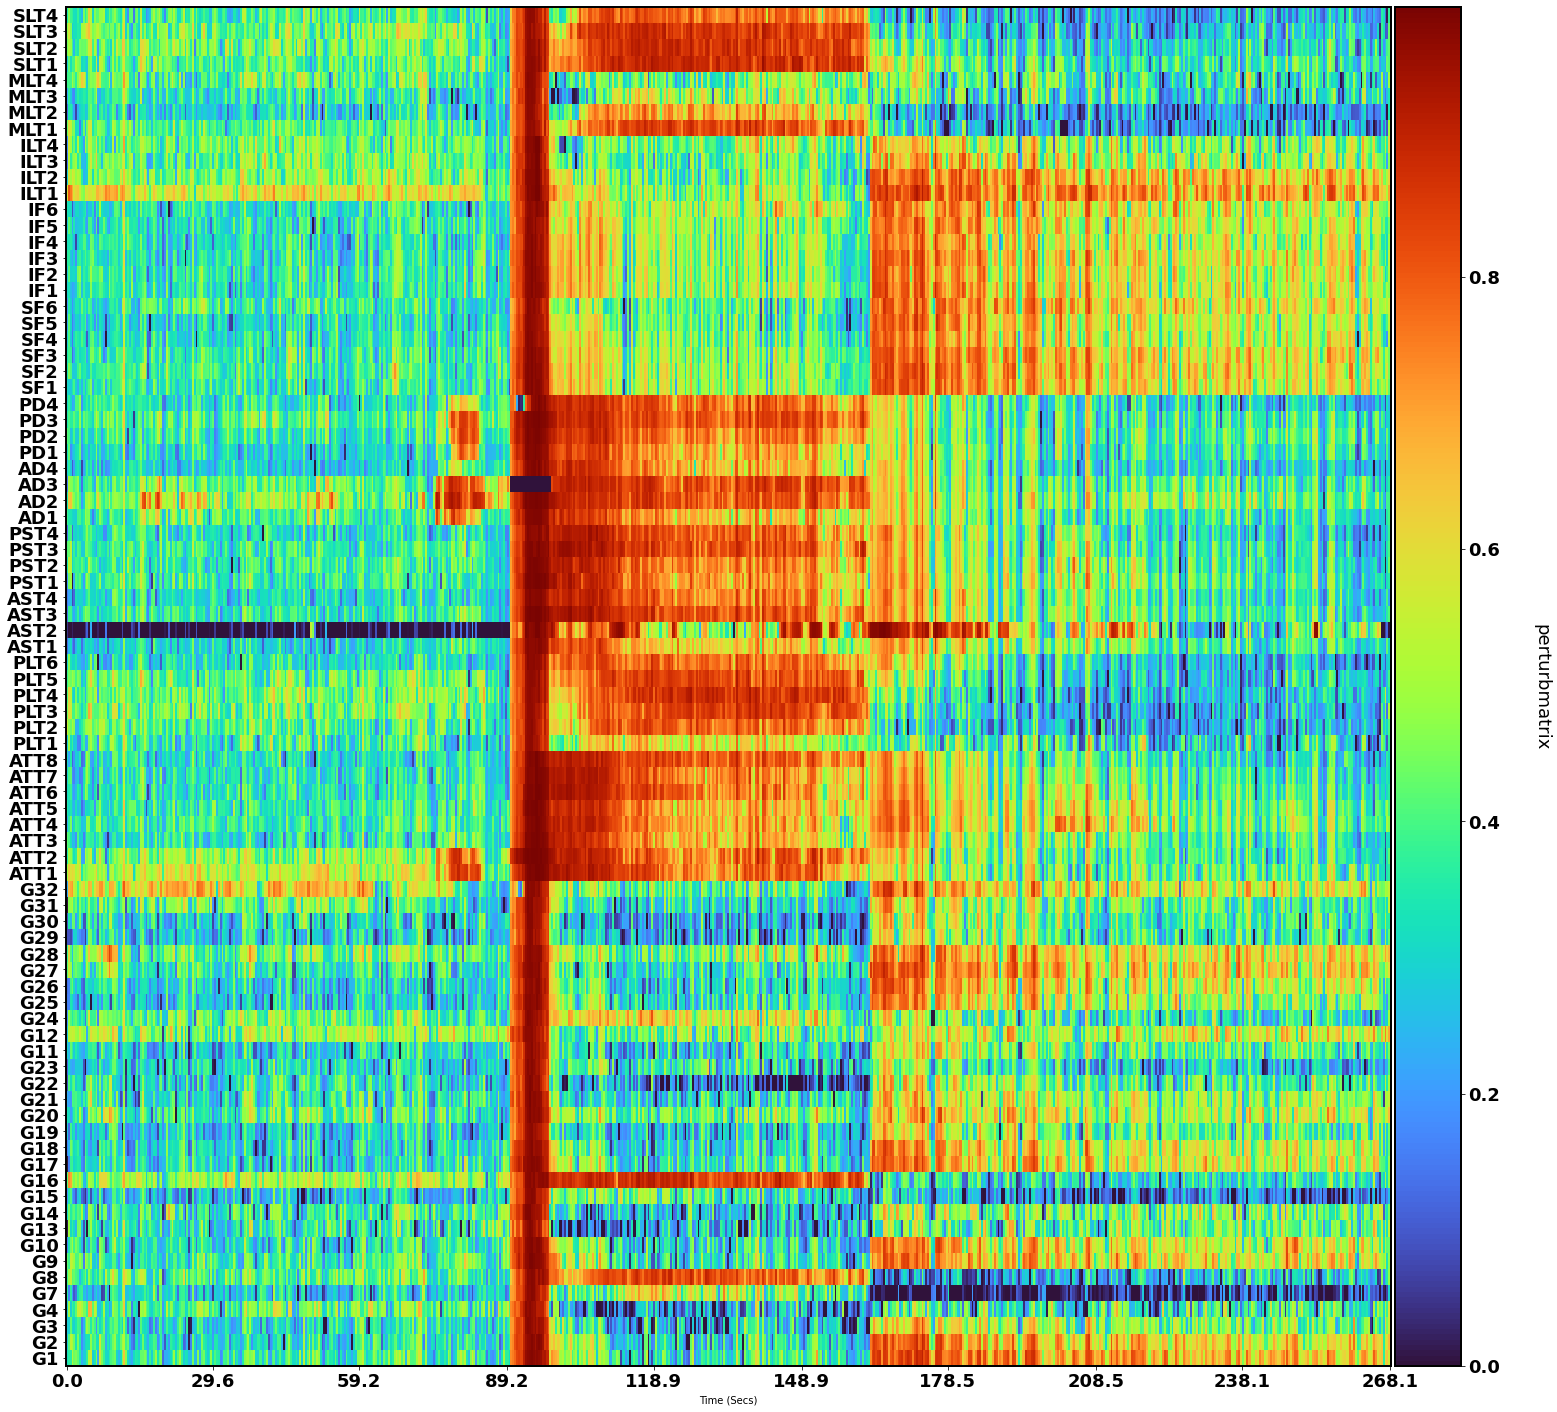

In [15]:

pert_deriv.normalize()
pert_deriv.plot_heatmap()

In [14]:
fragmats = []
pertmats = []

for i in range(5):
#     plt.figure()
#     sns.heatmap(Normalize().compute_fragilitymetric(pert_mats[:, i, :]), cmap='turbo')
    
    fragmats.append(Normalize().compute_fragilitymetric(pert_deriv[:, i, :]))
    pertmats.append(pert_mats[:,i,:])
    
print(np.array(pertmats).max(axis=0).shape)
buffmat = Normalize().compute_fragilitymetric(np.array(pertmats).max(axis=0))

buffmat = np.array(fragmats).max(axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(buffmat, cmap='turbo', yticklabels=raw.ch_names)

AttributeError: 'tuple' object has no attribute 'shape'

(84, 2151)


<AxesSubplot:>

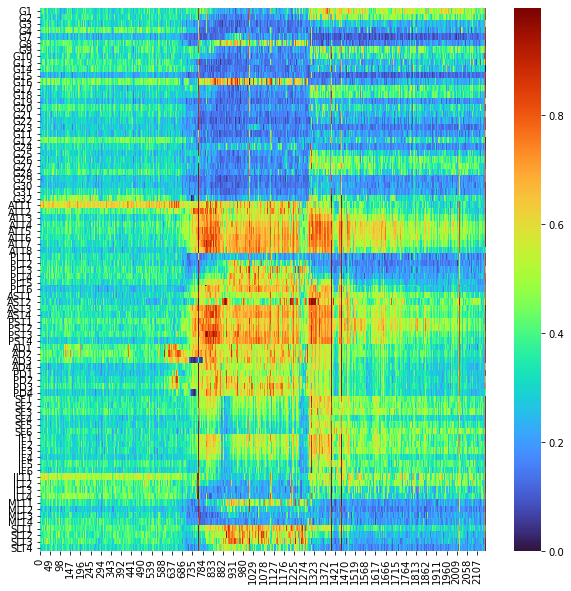

In [34]:
fragmats = []
pertmats = []

for i in range(5):
#     plt.figure()
#     sns.heatmap(Normalize().compute_fragilitymetric(pert_mats[:, i, :]), cmap='turbo')
    
    fragmats.append(Normalize().compute_fragilitymetric(pert_mats[:, i, :]))
    pertmats.append(pert_mats[:,i,:])
    
print(np.array(pertmats).max(axis=0).shape)
buffmat = Normalize().compute_fragilitymetric(np.array(pertmats).max(axis=0))

buffmat = np.array(fragmats).max(axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(buffmat, cmap='turbo', yticklabels=raw.ch_names)

NameError: name 'pertmat' is not defined

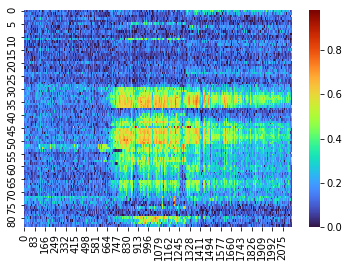

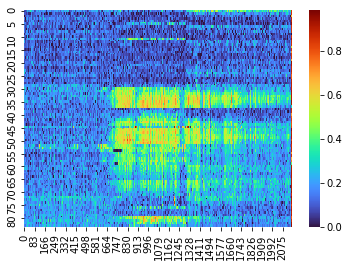

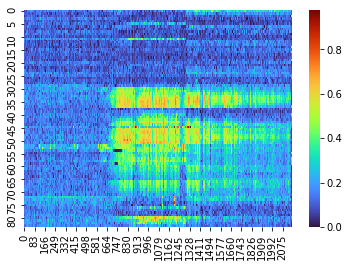

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure()
sns.heatmap(Normalize().compute_fragilitymetric(pert_mats[:, 0, :]), cmap='turbo')

plt.figure()
sns.heatmap(Normalize().compute_fragilitymetric(pert_mats[:, 1, :]), cmap='turbo')

plt.figure()
sns.heatmap(0.5*(Normalize().compute_fragilitymetric(pert_mats[:, 0, :]) + Normalize().compute_fragilitymetric(pert_mats[:, 1, :])), cmap='turbo')

plt.figure()
sns.heatmap(Normalize().compute_fragilitymetric(pertmat.get_data()), cmap='turbo')

# Run Algorithm on E1

In [8]:
rawcopy = raw.copy() #.crop(0, 5)
# rawcopy = rawcopy.resample(1000)

rawcopy.set_eeg_reference('average')
order = 2
print(rawcopy.info)

<Info | 11 non-empty values
 bads: []
 ch_names: C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, ...
 chs: 62 ECOG, 36 SEEG
 custom_ref_applied: True
 dig: 100 items (100 EEG)
 highpass: 0.5 Hz
 line_freq: 60
 lowpass: 300.0 Hz
 meas_date: 2017-01-01 08:33:20 UTC
 nchan: 98
 projs: []
 sfreq: 2049.2 Hz
 subject_info: 16 items (dict)
>


2412.7806835055426
2150.660038148791
(196, 196)


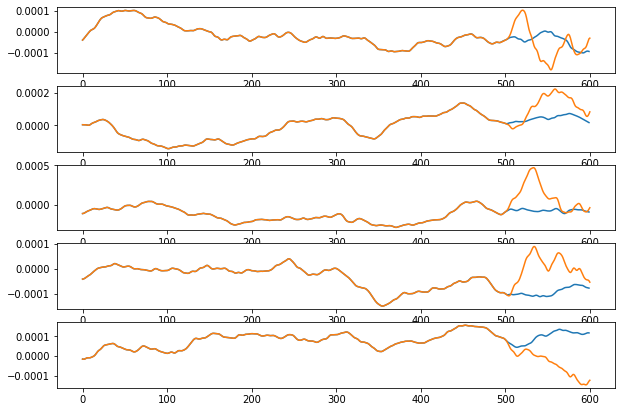

In [114]:
# def evaluate_order(raw, order):
sysid = SystemIDModel(
#     l2penalty=1e-10, 
    method_to_use='pinv',
#     svd_rank=0.95,
    order=order)

X = raw.get_data(start=100, stop=600)
Alist = sysid.fit(X)

lds = DiscreteLinearSystem(Alist)
print(np.linalg.cond(X))
print(lds.cond)
# testX = lds.reconstruct(X[:, 0], steps=500)
testX = lds.reconstruct(np.concatenate([X[:, i] for i in range(order)] ),
                                       steps=600)

fig, axs =plt.subplots(5, 1, figsize=(10, 7))
for i, ax in enumerate(axs.flat):
    ax.plot(raw.get_data(start=100, stop=700)[i, :])
    ax.plot(testX[i, :])
    
print(Alist.shape)
# for A in Alist:
#     lds = DiscreteLinearSystem(A)
    
#     testX = lds.reconstruct(X[:, 0], steps=1000)
    
#     fig, axs =plt.subplots(5, 1, figsize=(10, 7))
#     for i, ax in enumerate(axs.flat):
#         ax.plot(X[i, :])
#         ax.plot(testX[i, :])
        
#     print(lds.cond)
#     lds.plot_eigs()
    
#     break


2150.660038148791
1.017397232972888


<AxesSubplot:>

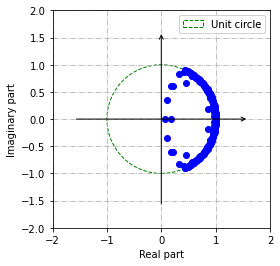

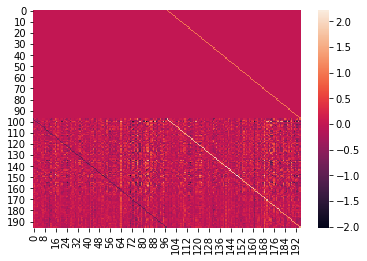

In [15]:
lds.plot_eigs()
print(lds.cond)
print(np.abs(lds.eigs).max())

plt.figure()
sns.heatmap(lds.A)

In [11]:
def transpose(A, order):
    
    A = A.copy().T
    
    n_chs = A.shape[0] / order
    start_col = n_chs * (order - 1)
    start_row = 0
    for idx in range(order):
        grid = np.ix_(np.arange(start_row, start_row+n_chs, dtype=int), 
                      np.arange(start_col, start_col+n_chs, dtype=int))
        # get the subset A matrix
        subA = A[grid]
        A[grid] = subA.T
        start_row += n_chs
    return A

In [11]:
transpose(lds.A, order=order).shape

(196, 196)

In [12]:
test = transpose(lds.A, order=order) - lds.A.T
print(np.sum(test))

-8.881784197001252e-15


In [14]:
print(lds.A[1, 99])

1.000000000000055


<AxesSubplot:>

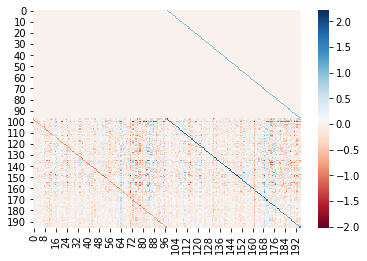

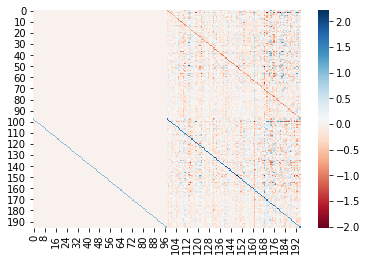

In [23]:
plt.figure()
sns.heatmap(Alist, cmap='RdBu')

plt.figure()
sns.heatmap(transpose(Alist, order), cmap='RdBu')

In [115]:
pertmodel = StructuredPerturbationModel(radius=1.5, 
                                        perturb_type='C')
print(pertmodel)

Structured Perturbation Model | radius=1.5, perturb_type=C


In [116]:
print(Alist.shape)
min_norm = pertmodel.fit(
#     Alist,
                        inner_transpose_multicompanion(Alist.T, order=2),
                         start=len(raw.ch_names), 
                         n_perturbations=len(raw.ch_names)
)
print(min_norm.shape)

(196, 196)
[2020-11-24 16:28:24,371] [adam2392] INFO [eztrack.utils._logging.compute_perturbations_at_indices:416] Perturbing matrix with condition number 2500.2626041929243 over 98 cols/rows.
(98,)


In [117]:
delta_vec = pertmodel.minimum_delta_vectors

print(delta_vec.shape)

(98, 196)


In [118]:
print(pertmodel)

Structured Perturbation Model | radius=1.5, perturb_type=C


<AxesSubplot:>

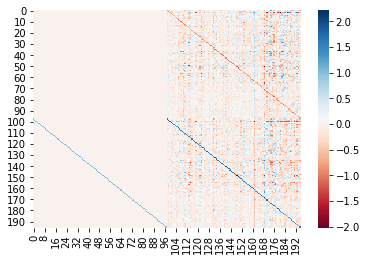

In [105]:
sns.heatmap(perturbedA, cmap='RdBu')

In [110]:
# plt.plot(min_norm)
# sns.heatmap(delta_vec)
n_chs = len(raw.ch_names)
for idx, vec in enumerate(delta_vec):
#     perturbedA = transpose(Alist, 2).copy()
    perturbedA = inner_transpose_multicompanion(Alist.T, 2)
    slice_idx = idx + n_chs
    perturbedA[:, slice_idx] = perturbedA[:, slice_idx] + vec

#     perturbedA = Alist.copy()
#     print(np.abs(np.linalg.eigvals(perturbedA)).max())
#     perturbedA[idx+n_chs, :] = perturbedA[idx+n_chs, :] + vec
#     perturbedA[idx, :] = perturbedA[idx, :] + vec
#     print(perturbedA.shape)
    print(np.abs(np.linalg.eigvals(perturbedA)).max())

1.5000000000000084
1.5000000000000016
1.499999999999985
1.5000000000000098
1.5000000000000044
1.499999999999998
1.5000000000000113
1.4999999999999918
1.500000000000002
1.499999999999997
1.4999999999999896
1.5000000000000042
1.499999999999989
1.500000000000002
1.5000000000000069
1.5000000000000104
1.4999999999999976
1.5000000000000042
1.5000000000000058
1.4999999999999976
1.5000000000000107
1.4999999999999964
1.5000000000000024
1.4999999999999971
1.4999999999999998
1.5000000000000049
1.4999999999999987
1.5000000000000056
1.5000000000000122
1.4999999999999913
1.4999999999999973
1.5000000000000069
1.5000000000000013
1.4999999999999898
1.5000000000000042
1.5000000000000022
1.4999999999999962
1.5000000000000064
1.4999999999999962
1.50000000000002
1.5000000000000036
1.5000000000000044
1.500000000000007
1.5000000000000082
1.5000000000000002
1.5000000000000047
1.5000000000000024
1.5000000000000042
1.500000000000006
1.5000000000000062
1.4999999999999982
1.4999999999999887
1.5000000000000004
1.5

In [10]:
print(order)
pert_mats, A_mats, delta_vecs_arr = lds_raw_fragility(rawcopy.crop(0, 2), order=order, return_all=True,
                                                      radius=1.25, winsize=500, stepsize=250)

Fragility Heatmap:   0%|          | 0/15 [00:00<?, ?eeg window/s]

2
Using pinv least squares with l2penalty 0.


Fragility Heatmap: 100%|██████████| 15/15 [00:00<00:00, 84.12eeg window/s]


(98,) (196, 196) (98, 196)


/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:128: RuntimeWarning: Channel names are not unique, found duplicates for: {'IPD4', 'C61', 'IPD6', 'MPOD1', 'IAD6', 'C21', 'SAD5', 'C42', 'C29', 'MAOD1', 'SPD1', 'C33', 'MAOD6', 'C3', 'MAOD3', 'C28', 'C39', 'MPOD2', 'C49', 'C8', 'C47', 'C52', 'C43', 'IPD3', 'C9', 'C20', 'SPD4', 'C7', 'C36', 'MPOD3', 'C22', 'MAOD4', 'IPD1', 'C23', 'MPOD5', 'C4', 'MPOD6', 'C60', 'C1', 'C30', 'C41', 'C27', 'C62', 'IPD5', 'C2', 'MAOD2', 'MPOD4', 'C63', 'C44', 'C32', 'IAD2', 'C16', 'IPD2', 'IAD3', 'C48', 'C14', 'SAD4', 'SPD6', 'C25', 'C12', 'C37', 'C24', 'C55', 'C31', 'C53', 'SPD5', 'MAOD5', 'C5', 'C46', 'C64', 'C13', 'C19', 'SPD2', 'C11', 'IAD4', 'C35', 'IAD5', 'C34', 'C58', 'C18', 'C26', 'C51', 'C38', 'SAD6', 'C59', 'C45', 'SAD1', 'C17', 'C40', 'C50', 'SAD3', 'C10', 'SAD2', 'IAD1', 'C54', 'C56', 'SPD3', 'C6'}. Applying running numbers for duplicates.
  mne_warn(message, category, module)
/Users/adam2392/Documents/sickkids/.venv/lib/python3.7/site-p

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

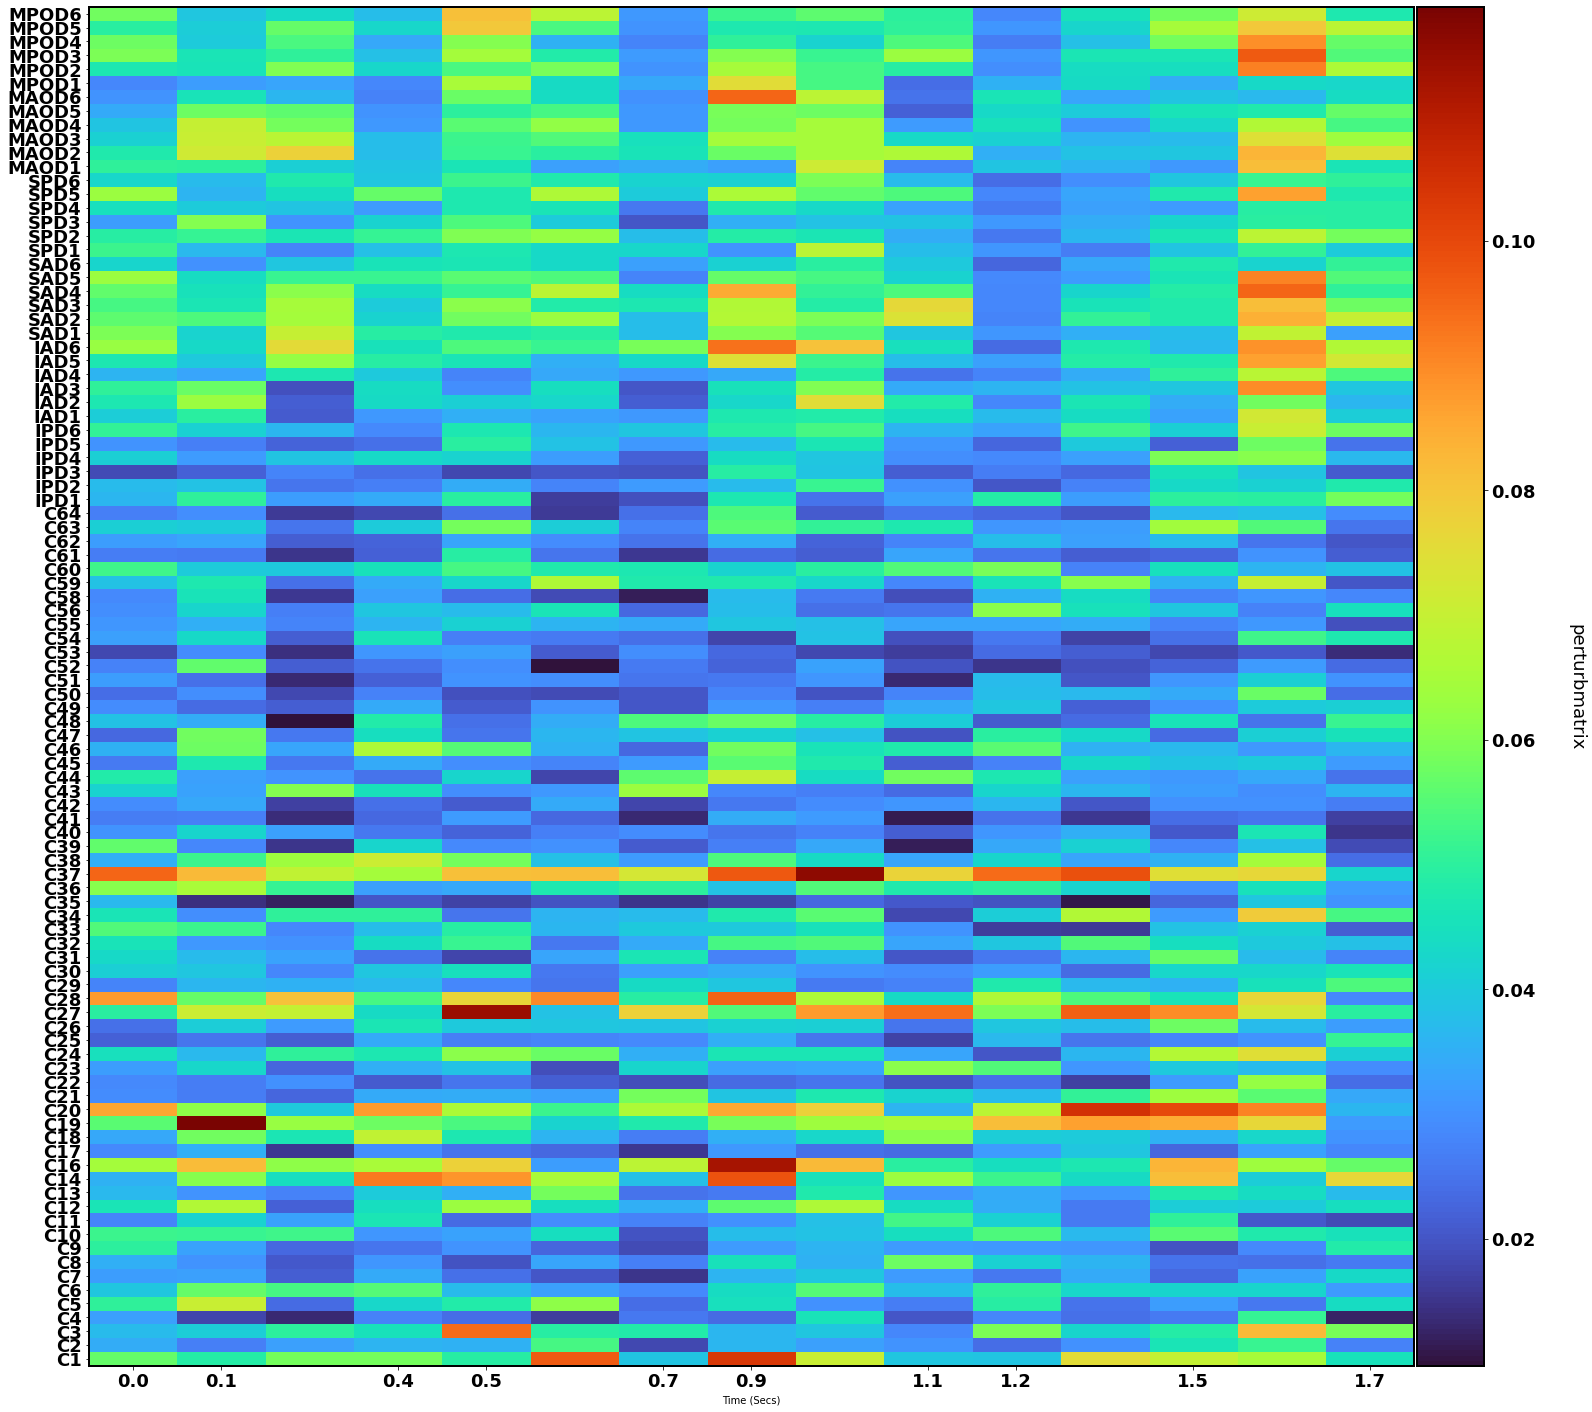

In [25]:
pert_mats.plot_heatmap()

In [20]:
print(pert_mats)
print(A_mats)
print(delta_vecs_arr.get_data(picks=[0,1,2], start=0, stop=10).shape)
print(delta_vecs_arr._data.shape)

<DerivativeArray | None,  - shape: ((98, 15)) (98 chs x 15 times) (1.7 s), ~210 kB, data loaded>
<DerivativeArray | None,  - shape: ((196, 196, 15)) (196 chs x 15 times) (1.7 s), ~4.8 MB, data loaded>
Slicing along ch axis: 0
[0 1 2]
(98, 196, 15)
(3, 196, 10)
(98, 196, 15)


# Brauer Perturbation

In [8]:
# def evaluate_order(raw, order):
sysid = SystemIDModel(
#     l2penalty=1e-10, 
    method_to_use='pinv',
#     svd_rank=0.95,
    order=1)

X = raw.get_data(start=100, stop=600)
A = sysid.fit(X)

In [10]:
delta_vec = compute_brauer_rank_one(A, radius=1.25+0.5j)

<AxesSubplot:>

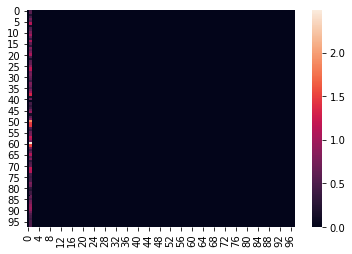

In [12]:
sns.heatmap(np.abs(delta_vec))

# Snapshot Data

In [117]:
X = rawcopy.get_data(start=0, stop=1000)
d = 12

snapshots = X

snaps = np.concatenate(
    [
        snapshots[:, i:snapshots.shape[1] - d + i + 1]
        for i in range(d)
    ],
    axis=0)
print(snaps.shape)

snapshot_A = snaps[:, :-1]  # x(t)
snapshot_B = snaps[:, 1:]  # x(t+1)
adjmat = snapshot_B.dot(np.linalg.pinv(snapshot_A))

print(adjmat.shape)

eegwin = X
n_chs, T = eegwin.shape

col_indices = np.arange(n_chs)
row_idx = np.arange(n_chs) + n_chs * (d - 1)
adjmat_list = []
for idx in range(d):
    grid_idx = np.ix_(row_idx, col_indices + (n_chs * idx))
    A = adjmat[grid_idx]
    adjmat_list.append(A)

print([x.shape for x in adjmat_list])
print(np.linalg.cond(eegwin))

(1176, 989)
(1176, 1176)
[(98, 98), (98, 98), (98, 98), (98, 98), (98, 98), (98, 98), (98, 98), (98, 98), (98, 98), (98, 98), (98, 98), (98, 98)]
3546.881906792319


In [130]:
mvarmodel = MvarModel(order=7)

In [131]:
adjmat_list = mvarmodel.fit(rawcopy.get_data(start=0, stop=500))

Condition number:  2390.678052449022
Max eigenvalue:  0.6759013138587004
Condition number:  989.3288860453183
Max eigenvalue:  0.6813380778736329
Condition number:  779.9292418767469
Max eigenvalue:  0.643287956745981
Condition number:  10048.896657940966
Max eigenvalue:  0.6198743923410903
Condition number:  423.3854090312653
Max eigenvalue:  0.5541288661400916
Condition number:  719.8005562243917
Max eigenvalue:  0.6154106068002884
Condition number:  770.455165540453
Max eigenvalue:  0.8342980445803883


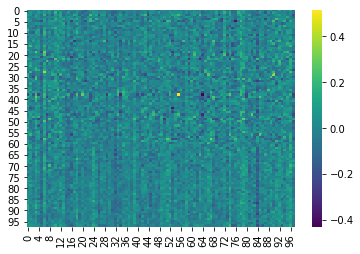

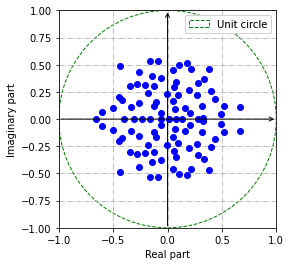

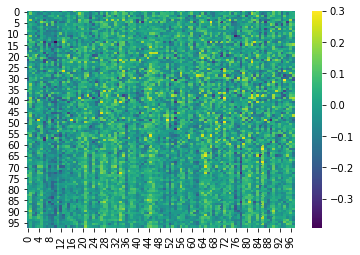

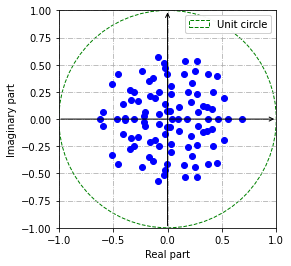

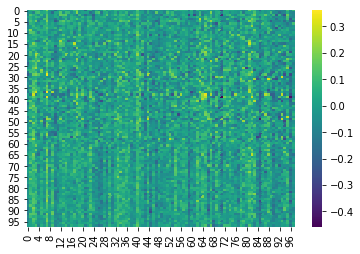

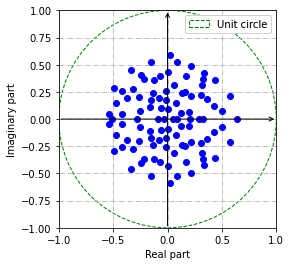

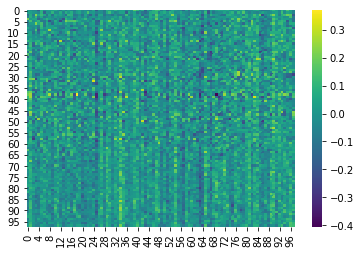

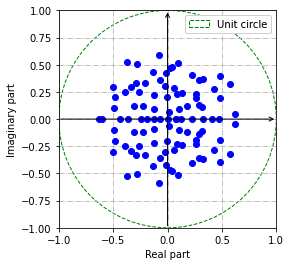

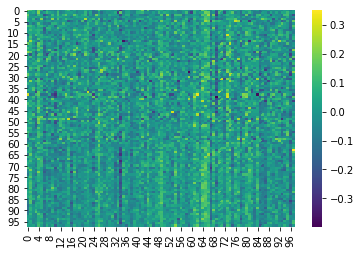

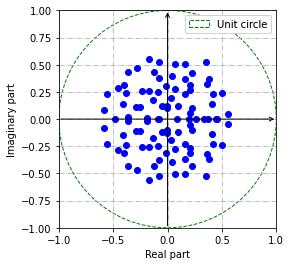

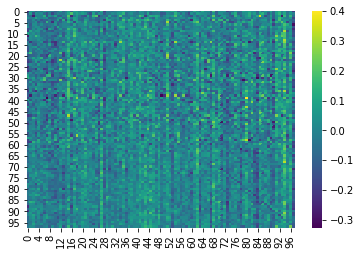

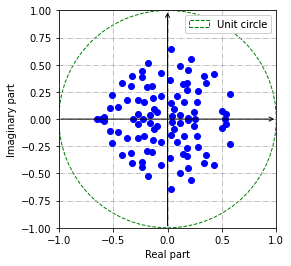

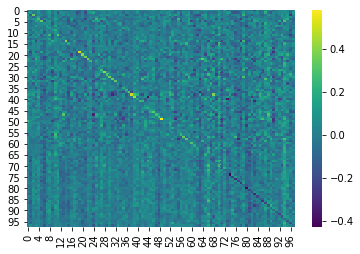

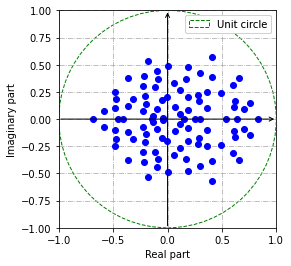

In [132]:
for x in adjmat_list:
    plt.figure()
    sns.heatmap(x, cmap='viridis')
    
    lds = DiscreteLinearSystem(x)
    lds.plot_eigs()
    print('Condition number: ', lds.cond)
    print('Max eigenvalue: ', np.abs(lds.eigs.max()))

In [10]:
pertmodel = MinNormPerturbModel(radius=1.0, perturb_type='C')

In [11]:
min_norms = pertmodel.fit(adjmat_list)

In [12]:
print([x.shape for x in min_norms])

[(84,), (84,), (84,), (84,), (84,)]


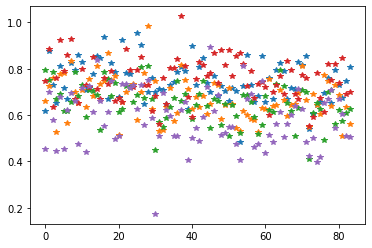

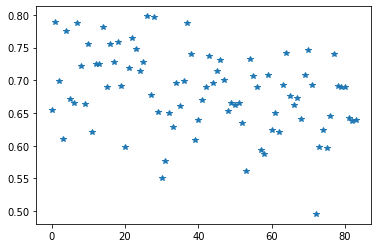

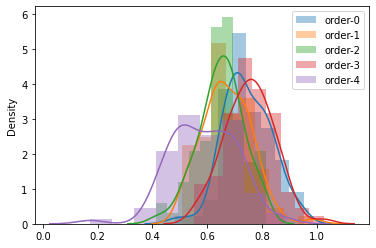

In [20]:
fig, ax = plt.subplots()
for x in min_norms:
    ax.plot(x, '*')
    
plt.figure()
plt.plot(np.mean(min_norms, axis=0), '*')

plt.figure()
for idx, x in enumerate(min_norms):
    sns.distplot(x, label=f'order-{idx}')
plt.legend()